In [2]:
import os
import sys

from copy import copy, deepcopy

import mne
import keras
import tensorflow as tf
from glob import glob

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)

## Constant Variable

In [44]:
SAMPLE_PATH = "DataVIN/HMI01/sample3/EEG.edf"
TIMESTAMP_PATH = "DataVIN/HMI01/sample3/EEGTimeStamp.txt"

## EEG preprocessing 

In [45]:
with open(TIMESTAMP_PATH, "r") as f:
    timestamp = f.readlines()

In [46]:
len(timestamp)

11520

In [47]:
raw = mne.io.read_raw_edf(SAMPLE_PATH, preload=True)

Extracting EDF parameters from /home/asus/Git/NLM_EEG_ET/DataVIN/HMI01/sample3/EEG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11519  =      0.000 ...    89.992 secs...


<ipython-input-47-6e6797215116>:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(SAMPLE_PATH, preload=True)


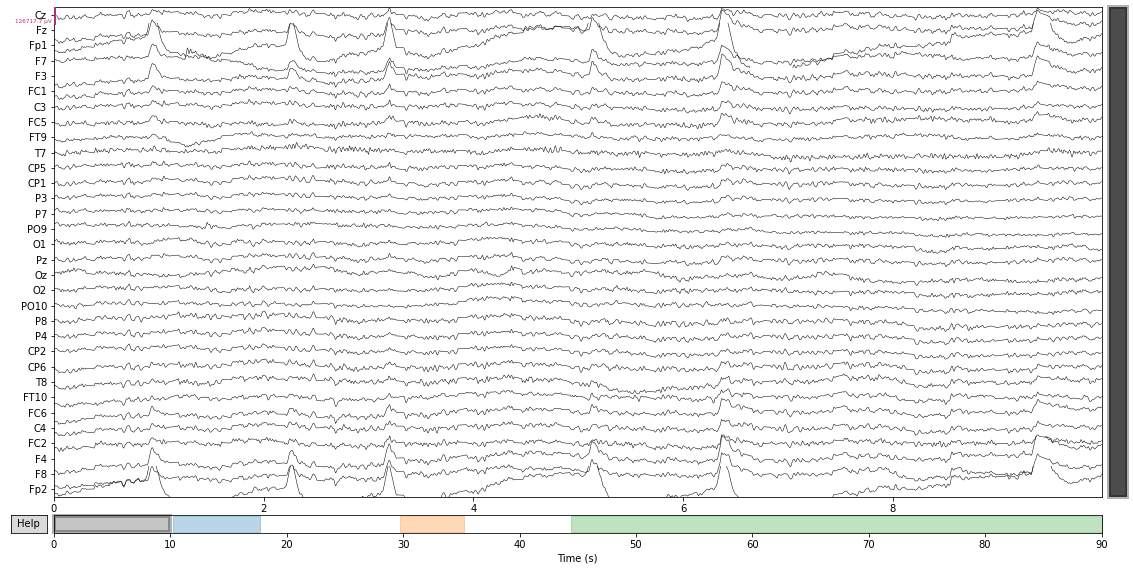

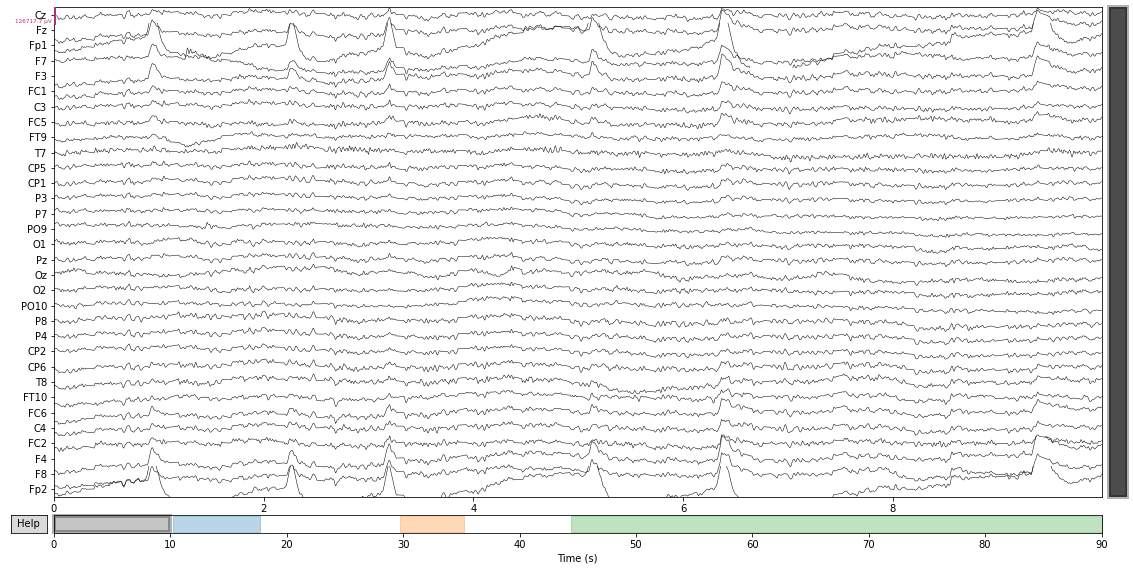

In [48]:
raw.plot(n_channels=32, duration=10, start=0.0, scalings="auto")

Effective window size : 16.000 (s)


<ipython-input-49-a5fcf744740b>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


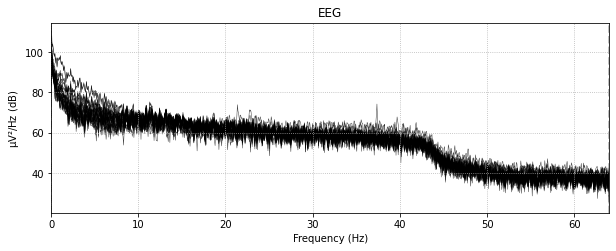

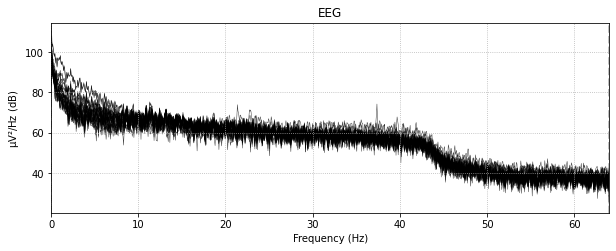

In [49]:
raw.plot_psd()

In [50]:
x_raw = raw.get_data()

In [51]:
x_raw.shape

(32, 11520)

## EEG preprocessing

In [52]:
raw_filter = raw.filter(0.5, 40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (6.602 sec)



In [53]:
ch_names = raw.ch_names

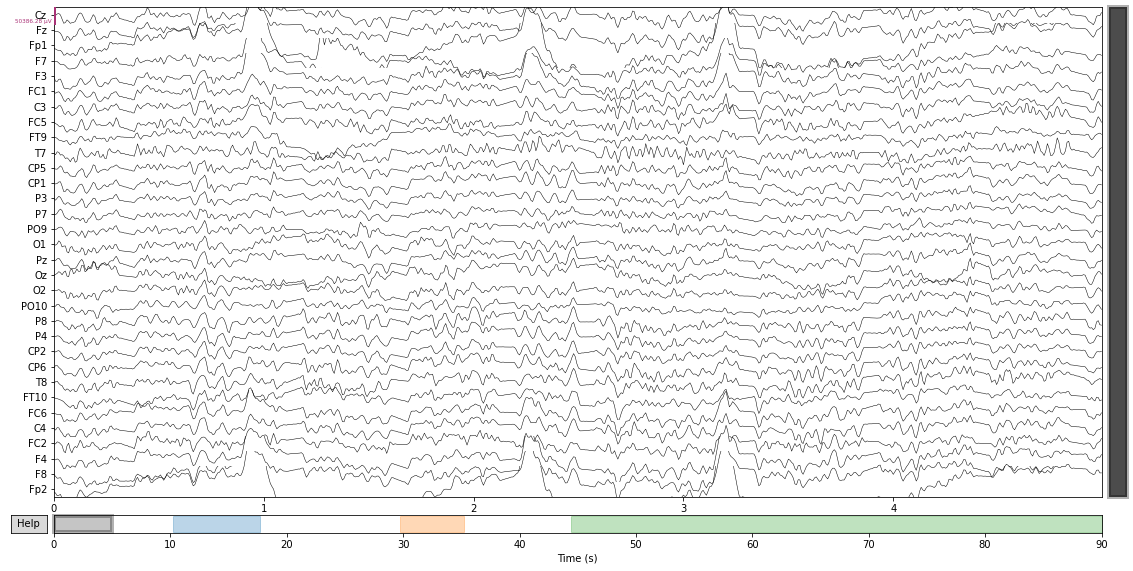

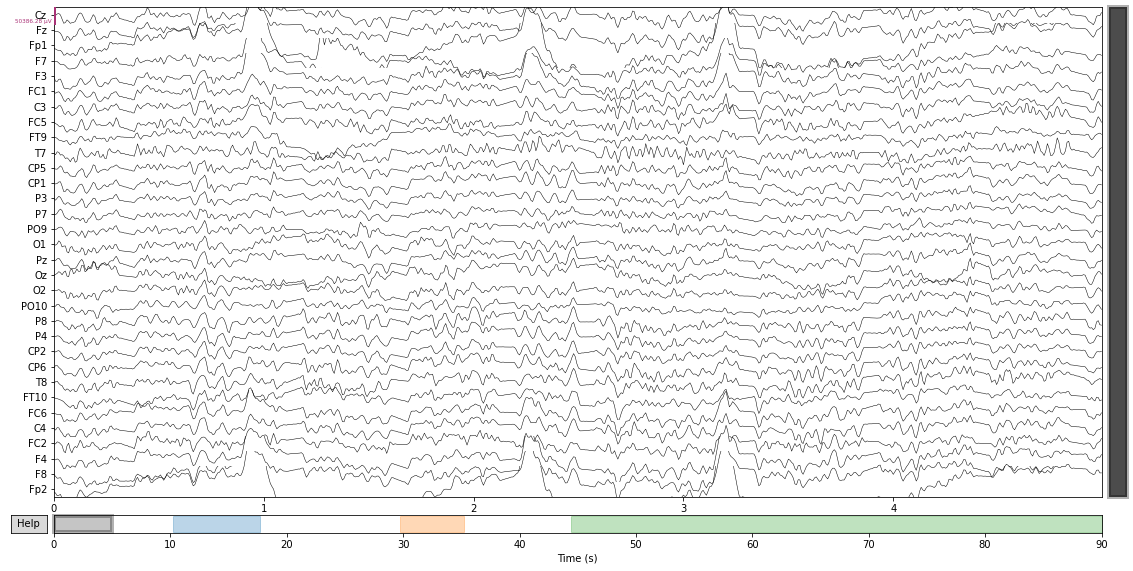

In [54]:
raw_filter.plot(n_channels=32, duration=5, start=0.0, scalings="auto")

Effective window size : 16.000 (s)


<ipython-input-55-63e7b8323d77>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filter.plot_psd()


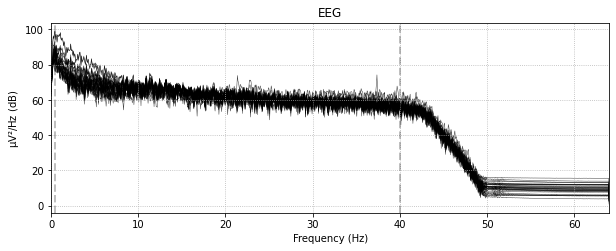

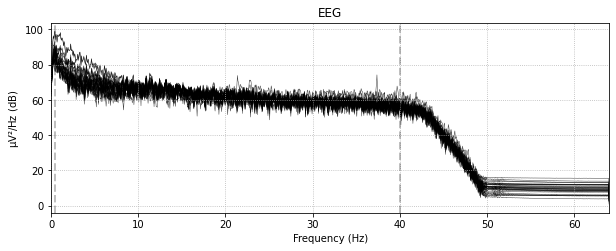

In [55]:
raw_filter.plot_psd()

In [56]:
ica = mne.preprocessing.ICA(n_components=32, random_state=0)

<ipython-input-56-f6fe7288eb0b>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=32, random_state=0)


In [57]:
ica.fit(raw_filter)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 1.1s.


<ICA | raw data decomposition, fit (fastica): 11520 samples, 32 components, channels used: "eeg">

Creating RawArray with float64 data, n_channels=32, n_times=11520
    Range : 0 ... 11519 =      0.000 ...    89.992 secs
Ready.


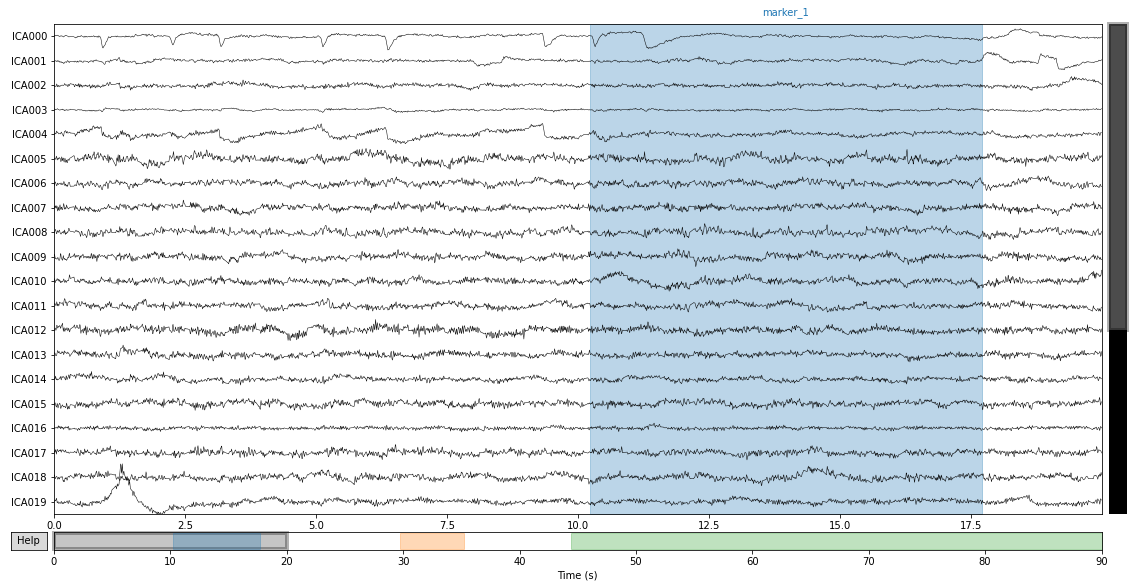

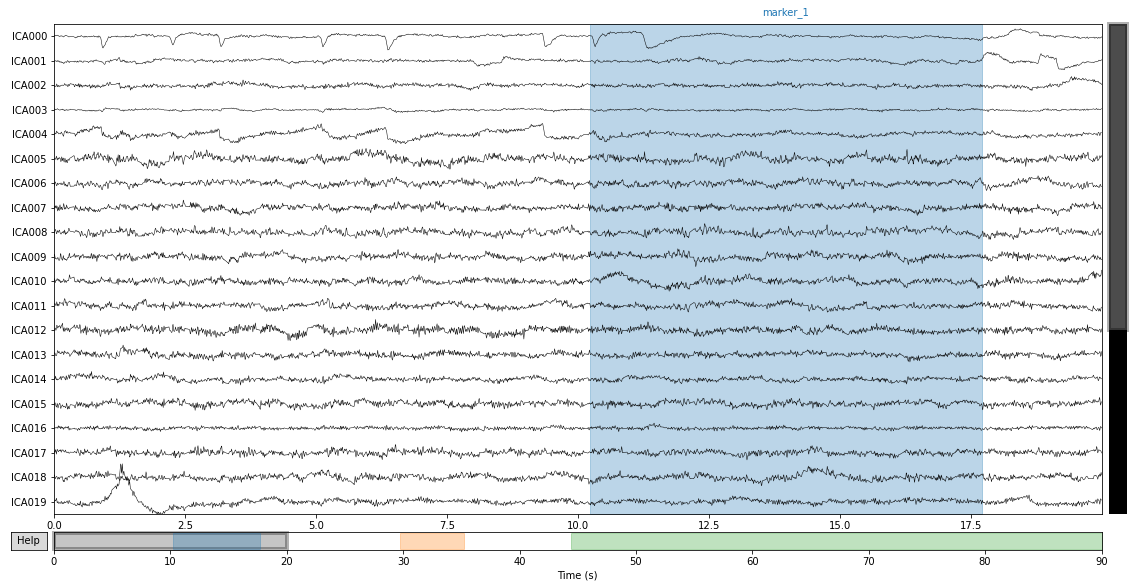

In [58]:
ica.plot_sources(raw_filter)

In [59]:
# ica.plot_components(outlines="skirt")

In [60]:
bad_indices_eog = {}
bad_indices_ecg = {}

for ch in ch_names:
    bad_indices_eog[ch] = []
    bad_indices_ecg[ch] = []

In [61]:
ica.find_bads_eog?

In [62]:
for ch in ch_names:
    bad_idx, scores = ica.find_bads_eog(raw_filter, ch, threshold=2.0)
    bad_indices_eog[ch] = bad_idx
    
    bad_idx_, scores_ = ica.find_bads_ecg(raw_filter, ch, threshold="auto")
    bad_indices_ecg[ch] = bad_idx_

Using EOG channel: Cz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
-

- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

Using threshold: 0.44 for CTPS ECG detection
Using channel F3 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1280 samples (10.000 sec)

Number of ECG events detected : 119 (average pulse 79 / min.)
Not setting metadata
Not setting metadata
119 matching events found
No baseline correction applied


- Filter length: 1280 samples (10.000 sec)

Number of ECG events detected : 122 (average pulse 81 / min.)
Not setting metadata
Not setting metadata
122 matching events found
No baseline correction applied
Loading data for 122 events and 129 original time points ...
0 bad epochs dropped
Using EOG channel: T7
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal band

- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

Using threshold: 0.44 for CTPS ECG detection
Using channel P7 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 1

- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1280 samples (10.000 sec)

Number of ECG events detected : 93 (average pulse 62 / min.)
Not setting metadata
Not setting metadata
93 matching events found
No baseline correction applied
Loading data for 93 events and 129 original time points ...
0 bad epochs dropped
Using EOG channel: O2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwid

- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

Using threshold: 0.44 for CTPS ECG detection
Using channel CP2 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------

- Filter length: 1280 samples (10.000 sec)

Using threshold: 0.44 for CTPS ECG detection
Using channel FC6 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1280 samples (10.000 sec)

Number of ECG events detected : 115 (average pulse 76 / min.)
Not setting metadata
Not setting metadata
115 matching events found
No baseline correction applied
Loading data for 115 events and 129 original time points ...
0 bad epochs dropped
Using EOG channel: C4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
De

Loading data for 123 events and 129 original time points ...
0 bad epochs dropped
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 1

In [65]:
bad_indices_eog

{'Cz': [6, 0, 14, 21],
 'Fz': [0, 14, 6],
 'Fp1': [0, 3, 14],
 'F7': [0, 1, 8, 11],
 'F3': [0, 6],
 'FC1': [0, 6, 14],
 'C3': [0, 6, 14, 9],
 'FC5': [0, 8, 6],
 'FT9': [1, 8, 0, 11, 20],
 'T7': [20, 9, 0, 11],
 'CP5': [0, 14, 13, 6, 9, 7, 5],
 'CP1': [7, 6, 5, 0, 9, 14],
 'P3': [5, 6, 0],
 'P7': [],
 'PO9': [22, 2, 31, 25],
 'O1': [5],
 'Pz': [6, 7],
 'Oz': [5, 7, 21],
 'O2': [5, 17],
 'PO10': [1, 22, 5, 11],
 'P8': [1, 5, 17, 14],
 'P4': [5, 1, 17],
 'CP2': [5],
 'CP6': [1, 0, 14],
 'T8': [1, 0, 30],
 'FT10': [1, 0, 8],
 'FC6': [0, 1, 14, 6, 4],
 'C4': [0, 1, 6],
 'FC2': [0, 16, 6],
 'F4': [0, 1],
 'F8': [0, 1, 4],
 'Fp2': [0, 1, 14]}

In [66]:
# for ch in ch_names:
raw_filter = ica.apply(raw_filter.copy(), exclude=[0,6,7])

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


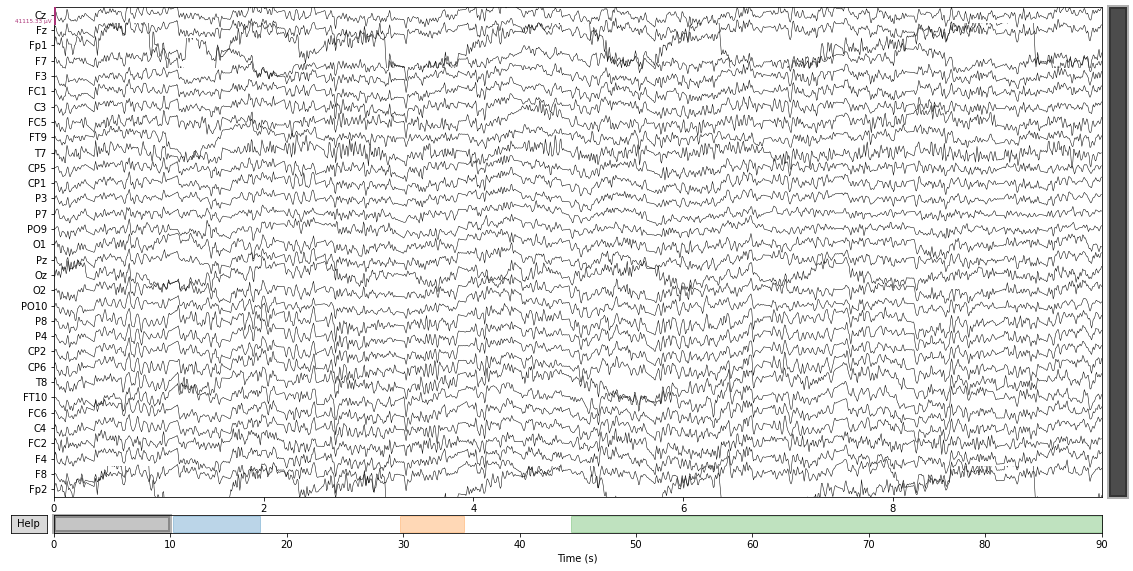

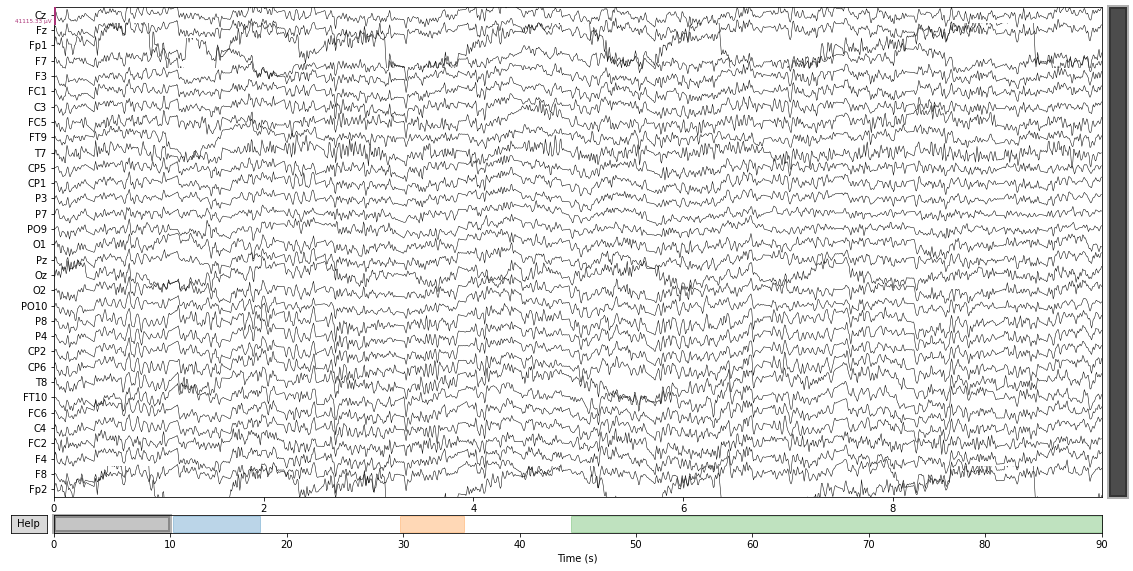

In [67]:
raw_filter.plot(n_channels=32, duration=10, start=0.0, scalings="auto")

In [68]:
events = mne.events_from_annotations(raw_filter)

Used Annotations descriptions: ['marker_1', 'marker_2', 'marker_3']


In [69]:
events[0].shape

(3, 3)

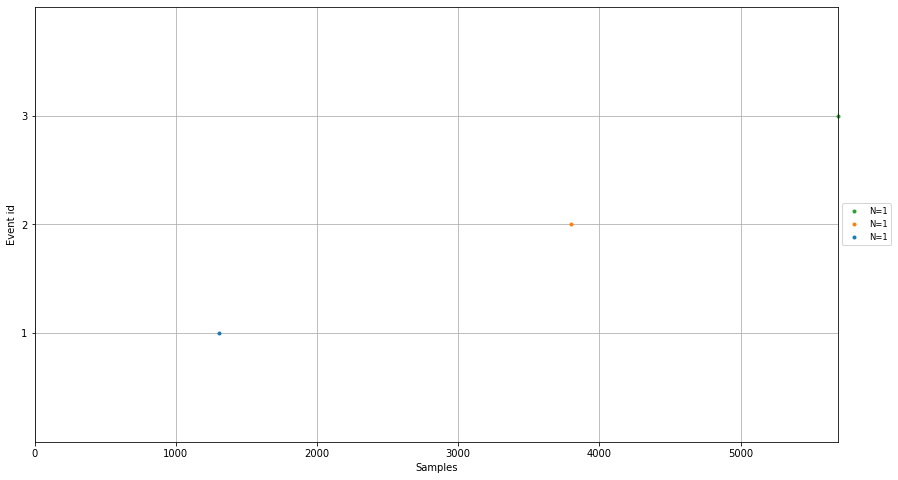

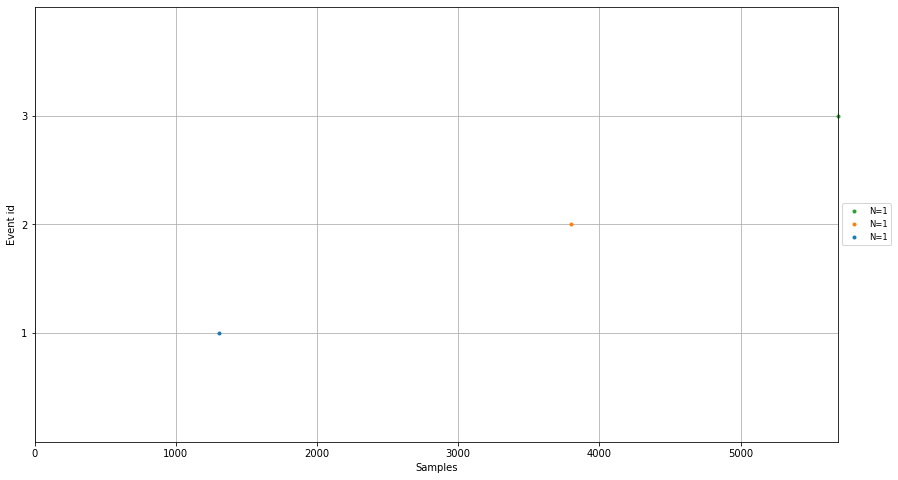

In [70]:
mne.viz.plot_events(events[0][:7])

In [71]:
event_ids = {"Typing": 3,
             "Thinking and Action": 2,
             "Thinking": 1}

In [72]:
epochs = mne.Epochs(raw_filter, events[0], event_id=event_ids, preload=True)

Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 91 original time points ...
0 bad epochs dropped


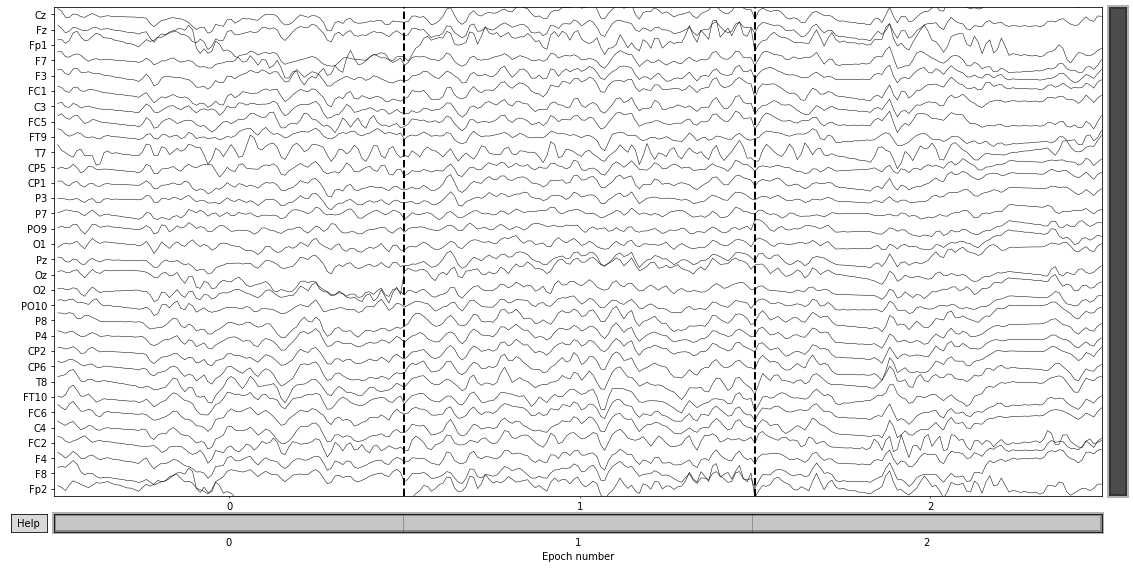

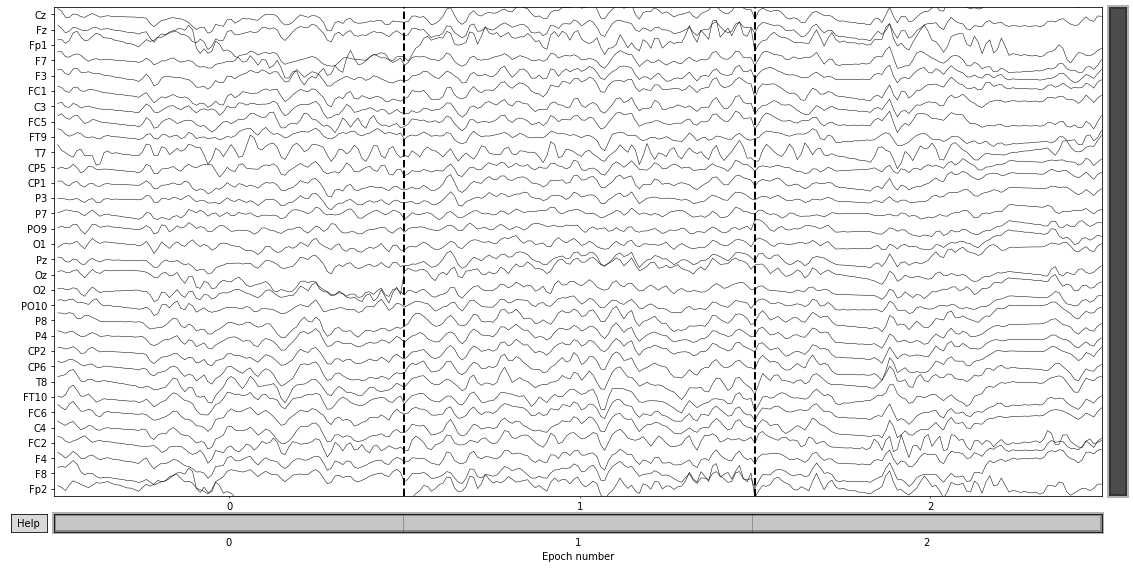

In [73]:
epochs.plot(n_channels=32, scalings="auto")

In [74]:
epochs = ica.apply(epochs, exclude=[0, 6, 7])

Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


<ipython-input-74-76c9e48c2106>:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs = ica.apply(epochs, exclude=[0, 6, 7])


In [75]:
epochs.apply_baseline((None, 0))

Applying baseline correction (mode: mean)


<Epochs |  3 events (all good), -0.203125 - 0.5 sec, baseline -0.203125 – 0 sec, ~104 kB, data loaded,
 'Thinking': 1
 'Thinking and Action': 1
 'Typing': 1>

Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-76-536d0ceca604>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks="Fp2")


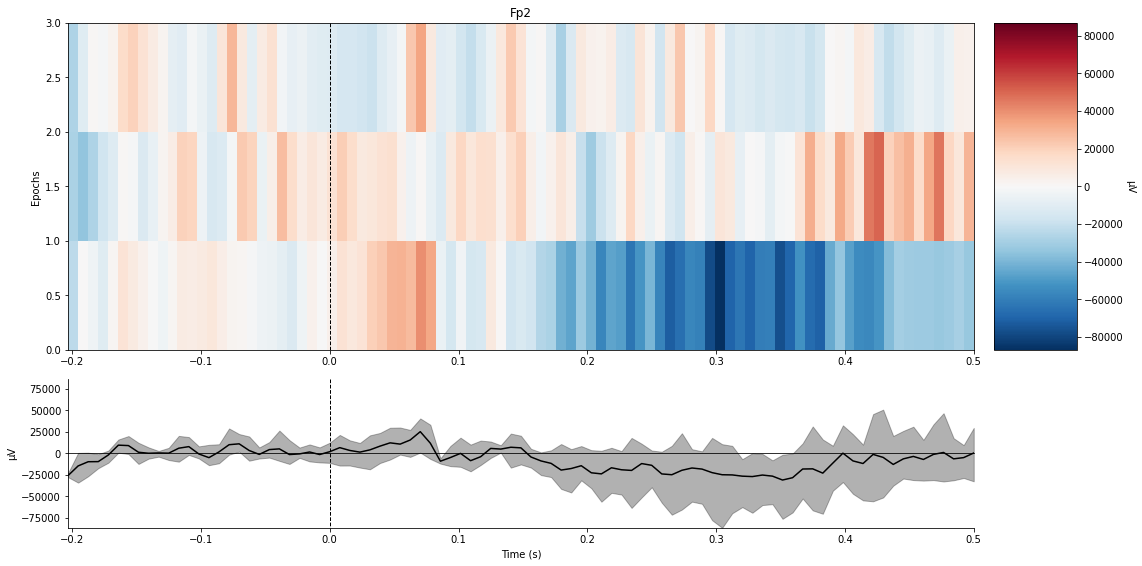

[<Figure size 1152x576 with 3 Axes>]

In [76]:
epochs.plot_image(picks="Fp2")

In [77]:
epochs.get_data().shape

(3, 32, 91)

In [78]:
e = epochs["Thinking and Action"]

In [79]:
raw.get_data().T[0]

array([-1.09656015e-04, -1.45439732e-04, -3.94982428e-04, -1.19072510e-04,
       -1.56244362e-04, -8.43866657e-05, -6.75547406e-05, -6.67393998e-05,
       -1.97514316e-05, -5.91873584e-05, -8.20710828e-05, -1.13989360e-04,
       -6.10557171e-05, -6.58555261e-05,  1.55958530e-05, -4.87690447e-05,
       -1.06232758e-04, -1.33900527e-04, -3.73399958e-05, -3.08306913e-05,
       -8.24342384e-05, -9.52128316e-05, -7.88187265e-05, -1.16490431e-04,
       -9.76406346e-05, -5.33162400e-05, -1.21523293e-04, -1.17378900e-04,
       -5.96591182e-05, -1.93770351e-04, -1.72382763e-04, -3.85194633e-04])

In [80]:
dir(raw)

['__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations',
 '_cals',
 '_check_bad_segment',
 '_comp',
 '_data',
 '_dtype',
 '_dtype_',
 '_filenames',
 '_first_samps',
 '_first_time',
 '_get_buffer_size',
 '_get_channel_positions',
 '_getitem',
 '_init_kwargs',
 '_last_samps',
 '_last_time',
 '_orig_units',
 '_parse_get_set_params',
 '_pick_drop_channels',
 '_pick_projs',
 '_preload_data',
 '_projector',
 '_projectors',
 '_raw_extras',
 '_raw_lengths',
 '_read_comp_grade',
 '_read_picks',
 '_read_segment',
 '_read_segment_file',
 '_reconstruct_proj'

In [39]:
raw_filter.save("DataVIN/HMI01/sample2/EEG_preprocessed.fif")

Writing /home/asus/Git/NLM_EEG_ET/DataVIN/HMI01/sample2/EEG_preprocessed.fif
Closing /home/asus/Git/NLM_EEG_ET/DataVIN/HMI01/sample2/EEG_preprocessed.fif
[done]


<ipython-input-39-5131cbc7fc40>:1: RuntimeWarning: This filename (/home/asus/Git/NLM_EEG_ET/DataVIN/HMI01/sample2/EEG_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filter.save("DataVIN/HMI01/sample2/EEG_preprocessed.fif")


In [41]:
raw_filter_from_file = mne.io.read_raw_fif("DataVIN/HMI01/sample2/EEG_preprocessed.fif", preload=True)

Opening raw data file DataVIN/HMI01/sample2/EEG_preprocessed.fif...
Isotrak not found
    Range : 0 ... 12159 =      0.000 ...    94.992 secs
Ready.
Reading 0 ... 12159  =      0.000 ...    94.992 secs...


<ipython-input-41-ae81a23573ff>:1: RuntimeWarning: This filename (DataVIN/HMI01/sample2/EEG_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filter_from_file = mne.io.read_raw_fif("DataVIN/HMI01/sample2/EEG_preprocessed.fif", preload=True)
